In [1]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt

import pywt
import pywt.data

In [2]:
def downsample_using_averaging(img):
    new_height = int(img.shape[0]/2)
    new_width = int(img.shape[1]/2)
    result = np.zeros([new_height, new_width], dtype=np.uint8)
    for i in range(new_height):
        for j in range(new_width):
            result[i,j] = int((img[i*2,j*2].astype(np.uint16) +\
                               img[i*2,j*2+1].astype(np.uint16) +\
                               img[i*2+1,j*2].astype(np.uint16) +\
                               img[i*2+1,j*2+1].astype(np.uint16))/4)
    return result
def upsample_with_replication(img):
    return np.repeat(np.repeat(img, 2, axis=1), 2, axis=0)
def get_image_compare_parameters(img1 , img2):
    mse = np.mean((img1 - img2)**2)
    rmse = math.sqrt(mse)
    max_intensity = 255
    psnr = 20*np.log10(max_intensity / rmse)
    
    
    return mse , psnr


# Manual Approximation using Mean

pixels in original image = 262144
max level count = 9.0
level = 1 , difference_mask_pixel_count = 262144
level = 2 , difference_mask_pixel_count = 65536
level = 3 , difference_mask_pixel_count = 16384
level = 4 , difference_mask_pixel_count = 4096
level = 5 , difference_mask_pixel_count = 1024
level = 6 , difference_mask_pixel_count = 256
level = 7 , difference_mask_pixel_count = 64
level = 8 , difference_mask_pixel_count = 16
level = 9 , difference_mask_pixel_count = 4
total pixel count in pyramid = 349525
level = 1 , difference_mask_pixel_count = 38970
level = 2 , difference_mask_pixel_count = 9363
level = 3 , difference_mask_pixel_count = 2098
level = 4 , difference_mask_pixel_count = 331
level = 5 , difference_mask_pixel_count = 39
level = 6 , difference_mask_pixel_count = 8
level = 7 , difference_mask_pixel_count = 1
level = 8 , difference_mask_pixel_count = 0
level = 9 , difference_mask_pixel_count = 0
total zero pixel count in pyramid = 50810
mse is 0


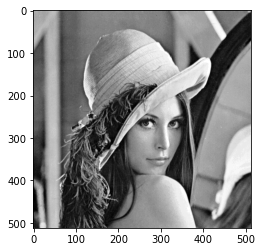

In [3]:
image = cv2.imread('../Images/6/Lena.bmp')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
original_image_pixel_count = image.shape[0] * image.shape[1]
print(f"pixels in original image = {original_image_pixel_count}")

class Pyramid:
    def __init__(self, image):
        self.approximation_images = [image]
        self.upsampled_images = []
        self.difference_masks = []

        
        print(f'max level count = {math.log2(image.shape[0])}')
        for i in range(int(math.log2(image.shape[0]))):
            self.approximation_images.append(downsample_using_averaging(self.approximation_images[i]))
            self.upsampled_images.append(upsample_with_replication(self.approximation_images[i+1]))
            self.difference_masks.append(self.approximation_images[i] - self.upsampled_images[i])

            cv2.imwrite(f'./lena_downsampled{i+1}.jpg' ,self.approximation_images[i+1] )

            
           
            
    def calc_pixel_count(self):
#         total_pixel_count = self.approximation_images[0].shape[0] * self.approximation_images[0].shape[1]
        total_pixel_count = 1
        for i in range(len(self.difference_masks)):
            difference_mask_pixel_count = self.difference_masks[i].shape[0] * self.difference_masks[i].shape[1]
            print(f'level = {i+1} , difference_mask_pixel_count = {difference_mask_pixel_count}')
            total_pixel_count += difference_mask_pixel_count 
        return total_pixel_count
    
    def calc_zero_pixel_count(self):
        total_pixel_count = 0
        for i in range(len(self.difference_masks)):
            difference_mask_zero_pixel_count = (self.difference_masks[i].flatten()  == 0 ).sum(0)
            print(f'level = {i+1} , difference_mask_pixel_count = {difference_mask_zero_pixel_count}')
            total_pixel_count += difference_mask_zero_pixel_count 
        return total_pixel_count
    def reconstruct_image(self ,lvl):
        
        # function to reconstruct picture from downsampled image and difference mask matrices
        reconstruct_image = self.approximation_images[lvl] # get smallest image
        reconstruct_image = upsample_with_replication(reconstruct_image)
        
        for i in list(reversed(range(lvl))):
            reconstruct_image = self.difference_masks[i] + reconstruct_image
            if i != 0:
                reconstruct_image = upsample_with_replication(reconstruct_image)
        return reconstruct_image
        
        

lena_pyramid = Pyramid(image)
print(f'total pixel count in pyramid = {lena_pyramid.calc_pixel_count() }')
print(f'total zero pixel count in pyramid = {lena_pyramid.calc_zero_pixel_count() }')
reconstructed_image = lena_pyramid.reconstruct_image(3)
plt.imshow(reconstructed_image , cmap="gray")
cv2.imwrite(f'./lena_recostructed.jpg' ,reconstructed_image )
try:
    mse , psnr = get_image_compare_parameters(image , reconstructed_image)
except ZeroDivisionError:
    mse = 0

print(f'mse is {mse}')

# Wavelet Pyramid and Wavelet Quantization

In [22]:
# Convert to float for more resolution for use with pywt
image = np.float32(image)
image /= 255

# Load image
LL = image
wavelet_pyramid = []
image_255 = image * 255 / image.max()

# Load image
quantized_LL = image
wavelet_pyramid_quantized = []

        
for i in range(3):
    coeffs2 = pywt.dwt2(LL, 'haar')
    LL, (LH, HL, HH) = coeffs2
    wavelet_pyramid.append((LH, HL, HH))
    
    LL = LL*255/LL.max()
    LH = LH*255/LH.max()
    HL = HL*255/HL.max()
    HH = HH*255/HH.max()
    cv2.imwrite(f'./lena_LL_wavelet{i}.jpg' , LL )
    cv2.imwrite(f'./lena_HH_wavelet{i}.jpg' , HH )
    cv2.imwrite(f'./lena_LH_wavelet{i}.jpg' , LH )
    cv2.imwrite(f'./lena_HL_wavelet{i}.jpg' , HL )

    

        
    # quantized image
    coeffs2 = pywt.dwt2(quantized_LL, 'haar')
    quantized_LL, (quantized_LH, quantized_HL, quantized_HH) = coeffs2

    LL_norm = quantized_LL*255/quantized_LL.max()
    LH_norm = quantized_LH*255/quantized_LH.max()
    HL_norm = quantized_HL*255/quantized_HL.max()
    HH_norm = quantized_HH*255/quantized_HH.max()
    step_size = 2
    quantized_LL = np.floor(LL_norm/step_size)*step_size
    quantized_LH = np.floor(LH_norm/step_size)*step_size
    quantized_HL = np.floor(HL_norm/step_size)*step_size
    quantized_HH = np.floor(HH_norm/step_size)*step_size
    
    mse , psnr = get_image_compare_parameters(quantized_LL , LL)
    print(f"level = {i} : mse = {mse} , psnr = {psnr}")
    cv2.imwrite(f'./lena_LL_wavelet_quantized{i}.jpg' , quantized_LL )
    cv2.imwrite(f'./lena_HH_wavelet_quantized{i}.jpg' , quantized_HH )
    cv2.imwrite(f'./lena_LH_wavelet_quantized{i}.jpg' , quantized_LH )
    cv2.imwrite(f'./lena_HL_wavelet_quantized{i}.jpg' , quantized_HL )
    wavelet_pyramid_quantized.append((quantized_LH, quantized_HL, quantized_HH))

    coefs_quantized = quantized_LL , (quantized_LH , quantized_HL , quantized_HH)
    inverted_quantized = pywt.idwt2(coefs_quantized, 'haar')

    if(i == 2):
        for j in list(reversed(range(3))):
            coeffs2 = LL,wavelet_pyramid[j]
            zero_count = 0
            
            for k in range(3):
                zero_count += (wavelet_pyramid[j][k].flatten() == 0).sum(0)
            
            print(f' j = {j} , zero_count={zero_count}')
            LL = pywt.idwt2(coeffs2, 'haar')
        LL *= 255/LL.max()
        cv2.imwrite(f'./lena_recostructed_wavelet.jpg' , LL )
        
    if(i == 2):
        for j in list(reversed(range(3))):
            coeffs2 = quantized_LL,wavelet_pyramid[j]
            zero_count = 0
            
            for k in range(3):
                zero_count += (wavelet_pyramid[j][k].flatten() == 0).sum(0)
            
            print(f' j = {j} , zero_count={zero_count}')
            quantized_LL = pywt.idwt2(coeffs2, 'haar')

        quantized_LL *= 255/quantized_LL.max()
        cv2.imwrite(f'./lena_recostructed_wavelet_quantized.jpg' , quantized_LL )
        mse , psnr = get_image_compare_parameters(quantized_LL , LL)
        
        print(f"reconstruct : mse = {mse} , psnr = {psnr}")
fig.tight_layout()
plt.show()

level = 0 : mse = 1.3186168670654297 , psnr = 46.929617341541515
level = 1 : mse = 2.5362331867218018 , psnr = 44.08891179855842
level = 2 : mse = 3.3344619274139404 , psnr = 42.90054597820222
 j = 2 , zero_count=13
 j = 1 , zero_count=1027
 j = 0 , zero_count=25932
 j = 2 , zero_count=13
 j = 1 , zero_count=1027
 j = 0 , zero_count=25932
reconstruct : mse = 0.44648057222366333 , psnr = 51.63277794753366


# Wavelet Denoising

In [ ]:
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio
# original = imread("./sample1.jpg")
original = imread('../Images/6/Lena.bmp')
sigma = 0.12
noisy = random_noise(original, var=sigma**2)
# noisy = imread("./sample1.jpg")
print(noisy.dtype)
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 10),
                       sharex=True, sharey=True)

plt.gray()

# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(noisy, multichannel=True, average_sigmas=True)
# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print(f"Estimated Gaussian noise standard deviation = {sigma_est}")

im_bayes = denoise_wavelet(noisy, multichannel=True, convert2ycbcr=True,
                           method='BayesShrink', mode='soft',
                           rescale_sigma=True)
im_visushrink = denoise_wavelet(noisy, multichannel=True, convert2ycbcr=True,
                                method='VisuShrink', mode='soft',
                                sigma=sigma_est, rescale_sigma=True)

# VisuShrink is designed to eliminate noise with high probability, but this
# results in a visually over-smooth appearance.  Repeat, specifying a reduction
# in the threshold by factors of 2 and 4.
im_visushrink2 = denoise_wavelet(noisy, multichannel=True, convert2ycbcr=True,
                                 method='VisuShrink', mode='soft',
                                 sigma=sigma_est/2, rescale_sigma=True)
im_visushrink4 = denoise_wavelet(noisy, multichannel=True, convert2ycbcr=True,
                                 method='VisuShrink', mode='soft',
                                 sigma=sigma_est/4, rescale_sigma=True)

im_visushrink8 = denoise_wavelet(noisy, multichannel=True, convert2ycbcr=True,
                                 method='VisuShrink', mode='soft',
                                 sigma=sigma_est/8, rescale_sigma=True)
# Compute PSNR as an indication of image quality
psnr_noisy = peak_signal_noise_ratio(original, noisy)
psnr_bayes = peak_signal_noise_ratio(original, im_bayes)
psnr_visushrink = peak_signal_noise_ratio(original, im_visushrink)
psnr_visushrink2 = peak_signal_noise_ratio(original, im_visushrink2)
psnr_visushrink4 = peak_signal_noise_ratio(original, im_visushrink4)

ax[0, 0].imshow(noisy)
ax[0, 0].axis('off')
ax[0, 0].set_title('Noisy\nPSNR={:0.4g}'.format(psnr_noisy))
ax[0, 1].imshow(im_bayes)
ax[0, 1].axis('off')
ax[0, 1].set_title(
    'Wavelet denoising\n(BayesShrink)\nPSNR={:0.4g}'.format(psnr_bayes))
ax[0, 2].imshow(im_visushrink)
ax[0, 2].axis('off')
ax[0, 2].set_title(
    'Wavelet denoising\n(VisuShrink, $\\sigma=\\sigma_{est}$)\n'
     'PSNR=%0.4g' % psnr_visushrink)
ax[1, 0].imshow(original)
ax[1, 0].axis('off')
ax[1, 0].set_title('Original')
ax[1, 1].imshow(im_visushrink2)
ax[1, 1].axis('off')
ax[1, 1].set_title(
    'Wavelet denoising\n(VisuShrink, $\\sigma=\\sigma_{est}/2$)\n'
     'PSNR=%0.4g' % psnr_visushrink2)
ax[1, 2].imshow(im_visushrink4)
ax[1, 2].axis('off')
ax[1, 2].set_title(
    'Wavelet denoising\n(VisuShrink, $\\sigma=\\sigma_{est}/4$)\n'
     'PSNR=%0.4g' % psnr_visushrink4)
fig.tight_layout()

plt.show()

In [ ]:
# print(im_bayes.shape)
noisy *= 255/ noisy.max()
im_bayes *= 255/ im_bayes.max()
im_visushrink *= 255/ im_visushrink.max()
im_visushrink2 *= 255/ im_visushrink2.max()
im_visushrink4 *= 255/ im_visushrink4.max()
im_visushrink8 *= 255/ im_visushrink8.max()
from skimage.io import imsave, imread

# imsave(f'./im_bayes.jpg', im_bayes.astype(np.uint8))
# imsave(f'./im_visushrink.jpg', im_visushrink.astype(np.uint8))
# imsave(f'./im_visushrink2.jpg', im_visushrink2.astype(np.uint8))
# imsave(f'./im_visushrink4.jpg', im_visushrink4.astype(np.uint8))
# imsave(f'./im_visushrink8.jpg', im_visushrink8.astype(np.uint8))

imsave(f'./noisy_lena.jpg', noisy.astype(np.uint8))
imsave(f'./im_bayes_lena.jpg', im_bayes.astype(np.uint8))
imsave(f'./im_visushrink_lena.jpg', im_visushrink.astype(np.uint8))
imsave(f'./im_visushrink2_lena.jpg', im_visushrink2.astype(np.uint8))
imsave(f'./im_visushrink4_lena.jpg', im_visushrink4.astype(np.uint8))
imsave(f'./im_visushrink8_lena.jpg', im_visushrink8.astype(np.uint8))